see https://github.com/bearpelican/musicautobot/tree/master/notebooks/music_transformer for code reference

This converts MID files (MIDI) to Tensor with musicautobot library API. 

In [6]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [7]:
import os
os.chdir('../../')

In [8]:
from utils.musicautobot.numpy_encode import *
from utils.musicautobot.config import *
from utils.musicautobot.music_transformer import *
from utils.musicautobot.multitask_transformer import *
from utils.musicautobot.utils import midifile

# Encoding Midi Files to Tensor

Step by step on transforming a MIDI file into a tensor.
This notebook is more of an FYI, as the details are not necessary for training

#### For a more high level API, see `MusicItem`

MusicItem wraps all these functions in a simplified API. See this [notebook](MusicItem-Transform.ipynb) for more details

## Overview

Start with something that looks like this:

In [9]:
midi_file = Path('./data/notebook_examples/example.mid')
vocab = MusicVocab.create()
item = MusicItem.from_file(midi_file, vocab); 
item.show()

FileNotFoundError: Cannot find file in data/notebook_examples/example.mid

And end up with a Tensor that looks like this:

In [ ]:
item.to_tensor()

tensor([  0,   1,   8,  ..., 138,  34, 138])

## Basic Steps:

A basic step by step process to show how the library encodes a midi file like this:

1. MidiFile - Load a single midi file
2. Music21 Stream - Python Library helps with manipulating music files
3. Chord Encoding - Encode stream to a sparse matrix
4. Note Encoding - Intermediate dense matrix encoding
5. Tensor Encoding - Final single tensor for training

## 1. MidiFile

[MIDI](https://en.wikipedia.org/wiki/MIDI) is a standardized digital music representation that looks like this:

In [ ]:
mf = midifile.file2mf(midi_file); mf
print(mf)

<music21.midi.MidiFile 2 tracks>


## 2. Music21 Stream

[Music21](https://web.mit.edu/music21/) is powerful python library that helps us manipulate these MIDI files

In [ ]:
stream = file2stream(mf)

In [ ]:
stream.show('text')

{0.0} <music21.stream.Part 0x7feedc32a6b0>
    {0.0} <music21.stream.Measure 1 offset=0.0>
        {0.0} <music21.instrument.Piano 'Melody: Piano'>
        {0.0} <music21.instrument.Piano 'Melody: Piano'>
        {0.0} <music21.clef.TrebleClef>
        {0.0} <music21.meter.TimeSignature 4/4>
        {0.0} <music21.note.Note C>
        {1.0} <music21.note.Note D>
        {2.0} <music21.note.Note E>
        {4.0} <music21.bar.Barline type=final>
{0.0} <music21.stream.Part 0x7feedc328610>
    {0.0} <music21.stream.Measure 1 offset=0.0>
        {0.0} <music21.instrument.Piano 'Chords: Piano'>
        {0.0} <music21.instrument.Piano 'Chords: Piano'>
        {0.0} <music21.clef.BassClef>
        {0.0} <music21.meter.TimeSignature 4/4>
        {0.0} <music21.chord.Chord A2 E3>
        {2.0} <music21.chord.Chord C3 G3>
        {4.0} <music21.bar.Barline type=final>


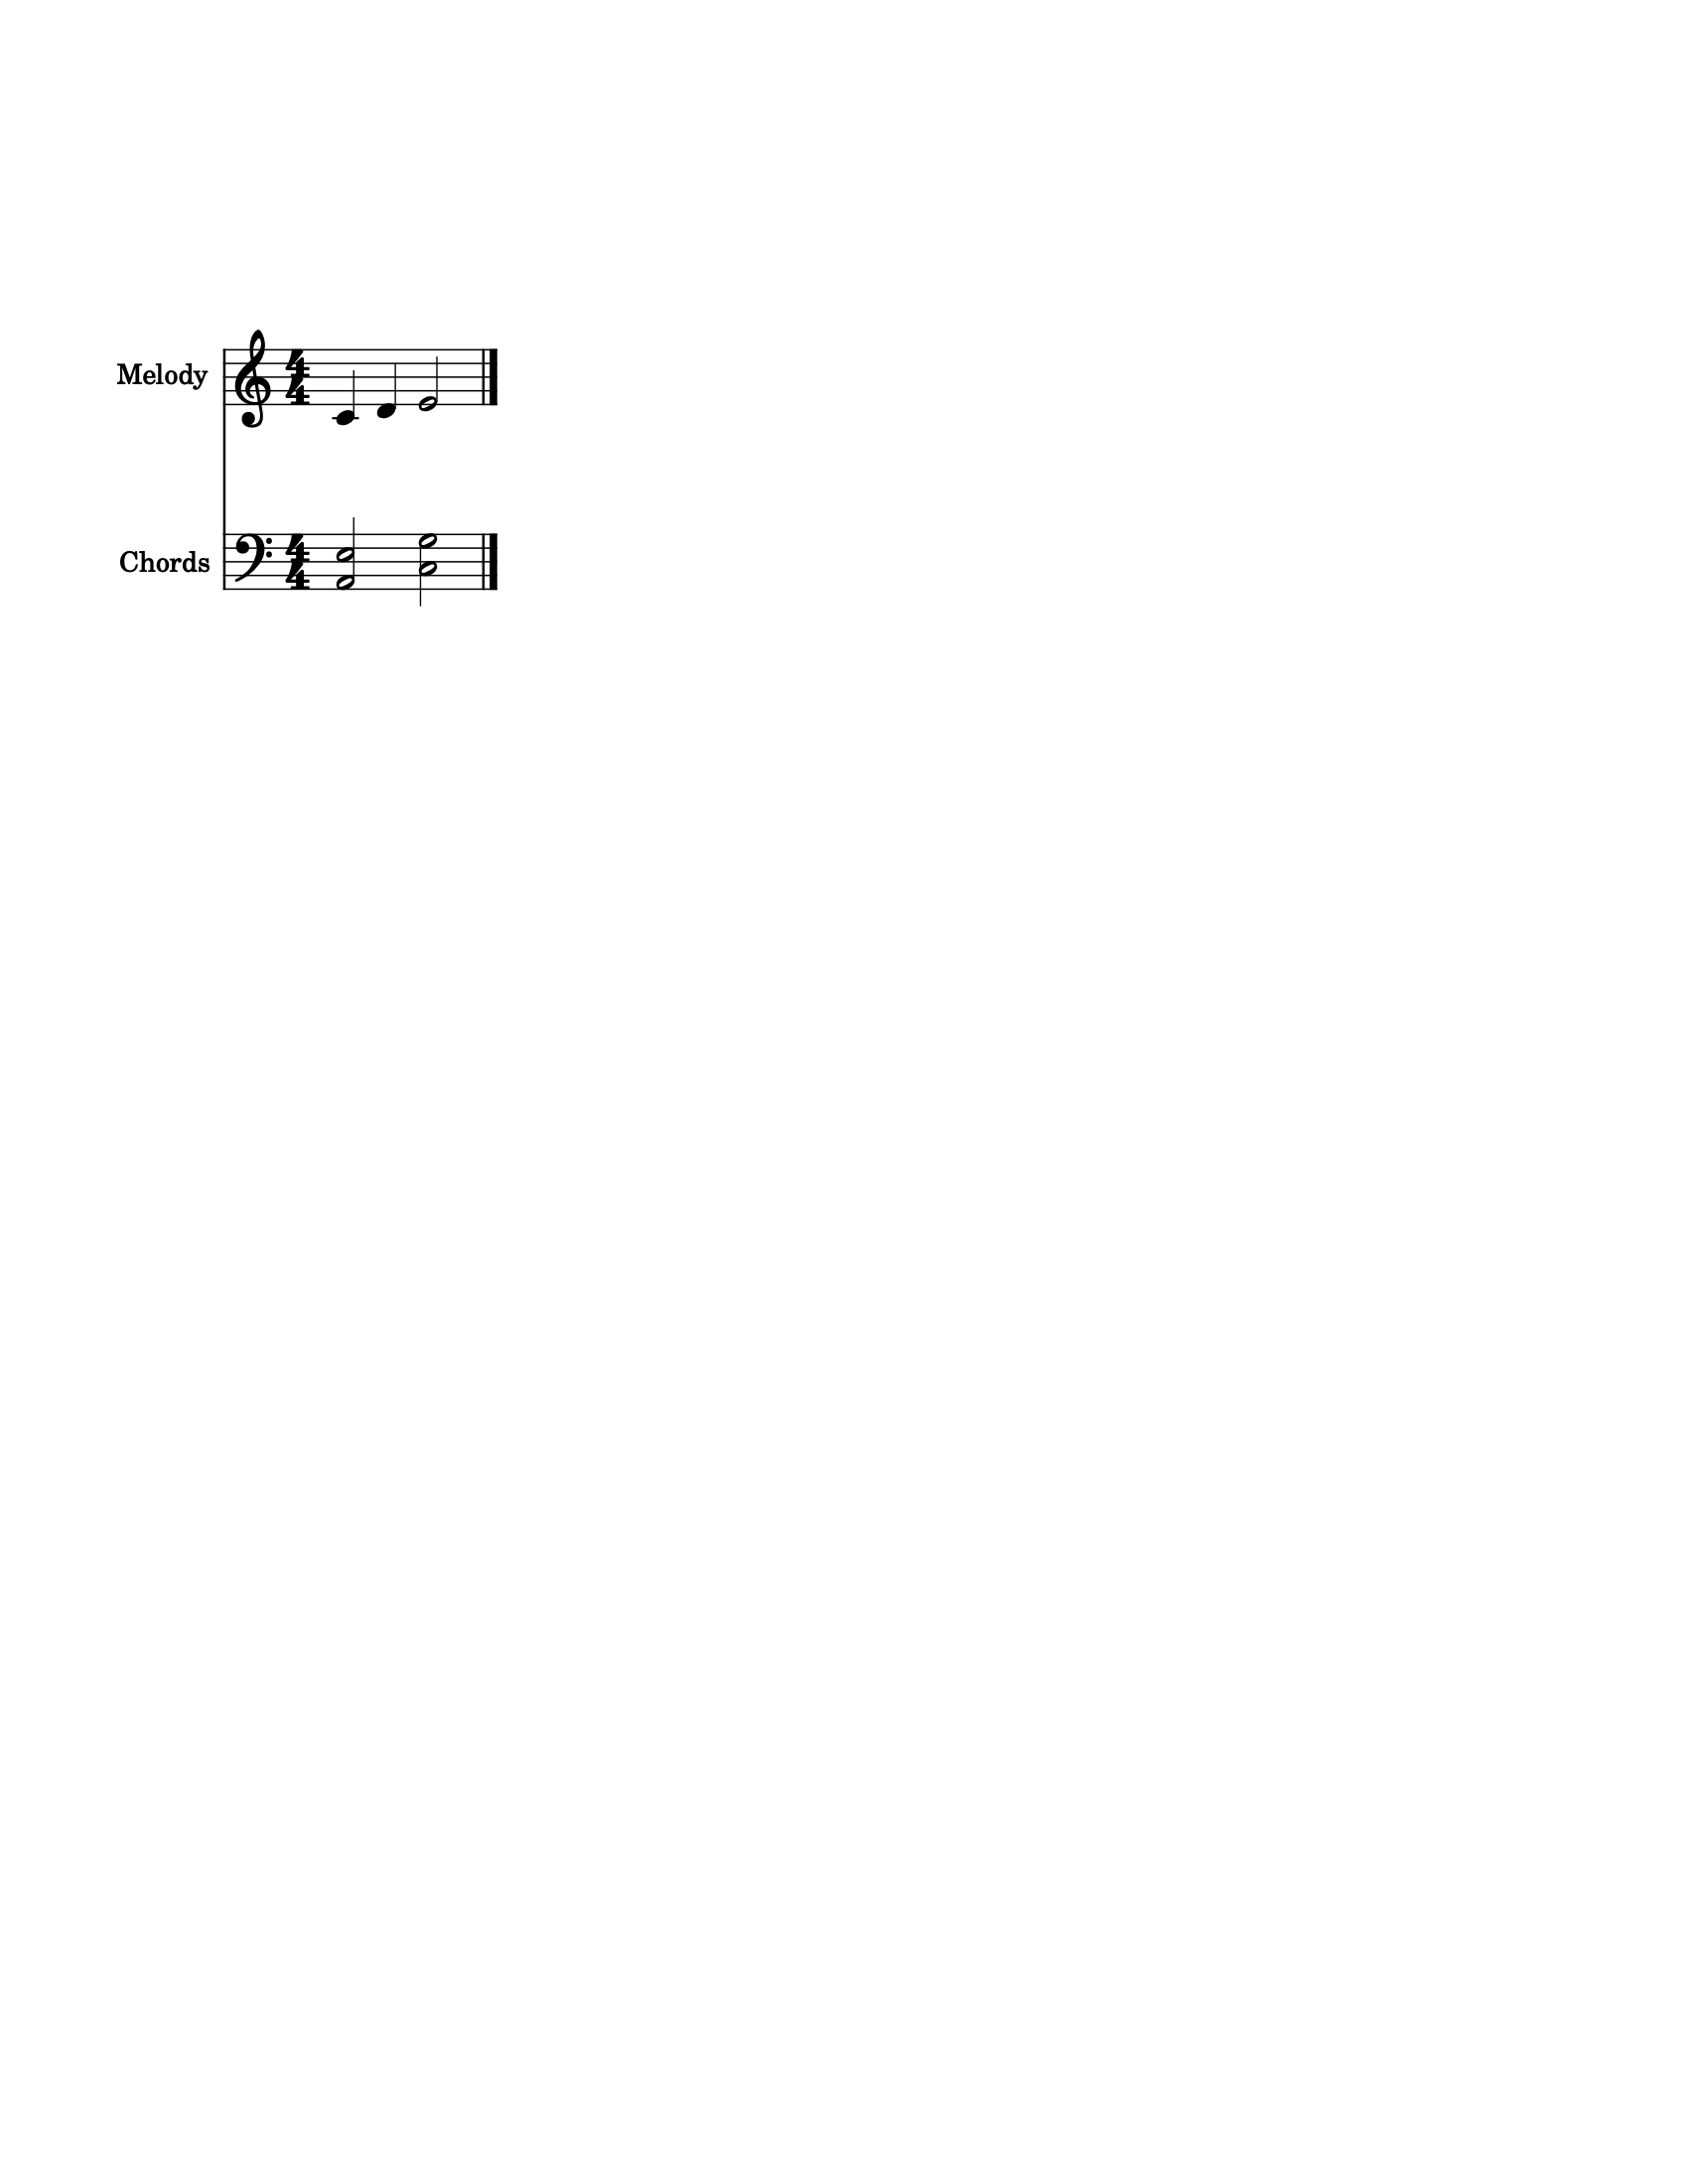

In [ ]:
stream.show()

In [ ]:
stream.show('midi')

## 3. Chord Encoding

Take the music21 stream object and encode it into a sparse numpy matrix. This matrix represents which notes are played at which timesteps

In [ ]:
chordarr = stream2chordarr(stream); chordarr.shape

(17, 2, 128)

##### Chord Encoding Dimensions - (timestep x track x notes)


17 = timesteps in song  
2 = tracks/parts (track 1 = melody, track 2 = chords)  
128 = midi pitch range - [reference](https://www.inspiredacoustics.com/en/MIDI_note_numbers_and_center_frequencies)  

##### Representation

In [ ]:
chordarr

array([[[0., 0., 0., 0., ..., 0., 0., 0., 0.],
        [0., 0., 0., 0., ..., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., ..., 0., 0., 0., 0.],
        [0., 0., 0., 0., ..., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., ..., 0., 0., 0., 0.],
        [0., 0., 0., 0., ..., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., ..., 0., 0., 0., 0.],
        [0., 0., 0., 0., ..., 0., 0., 0., 0.]],

       ...,

       [[0., 0., 0., 0., ..., 0., 0., 0., 0.],
        [0., 0., 0., 0., ..., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., ..., 0., 0., 0., 0.],
        [0., 0., 0., 0., ..., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., ..., 0., 0., 0., 0.],
        [0., 0., 0., 0., ..., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., ..., 0., 0., 0., 0.],
        [0., 0., 0., 0., ..., 0., 0., 0., 0.]]])

In [ ]:
# First timestep
ts1 = chordarr[0].nonzero(); ts1

(array([0, 1, 1]), array([60, 45, 52]))

First timestep, contains the midi notes 72, 45, 48, 52.  
Equivalent to (C5 A2 C3 E3)

In [ ]:
c = music21.chord.Chord(ts1[1].tolist()); c

<music21.chord.Chord C4 A2 E3>

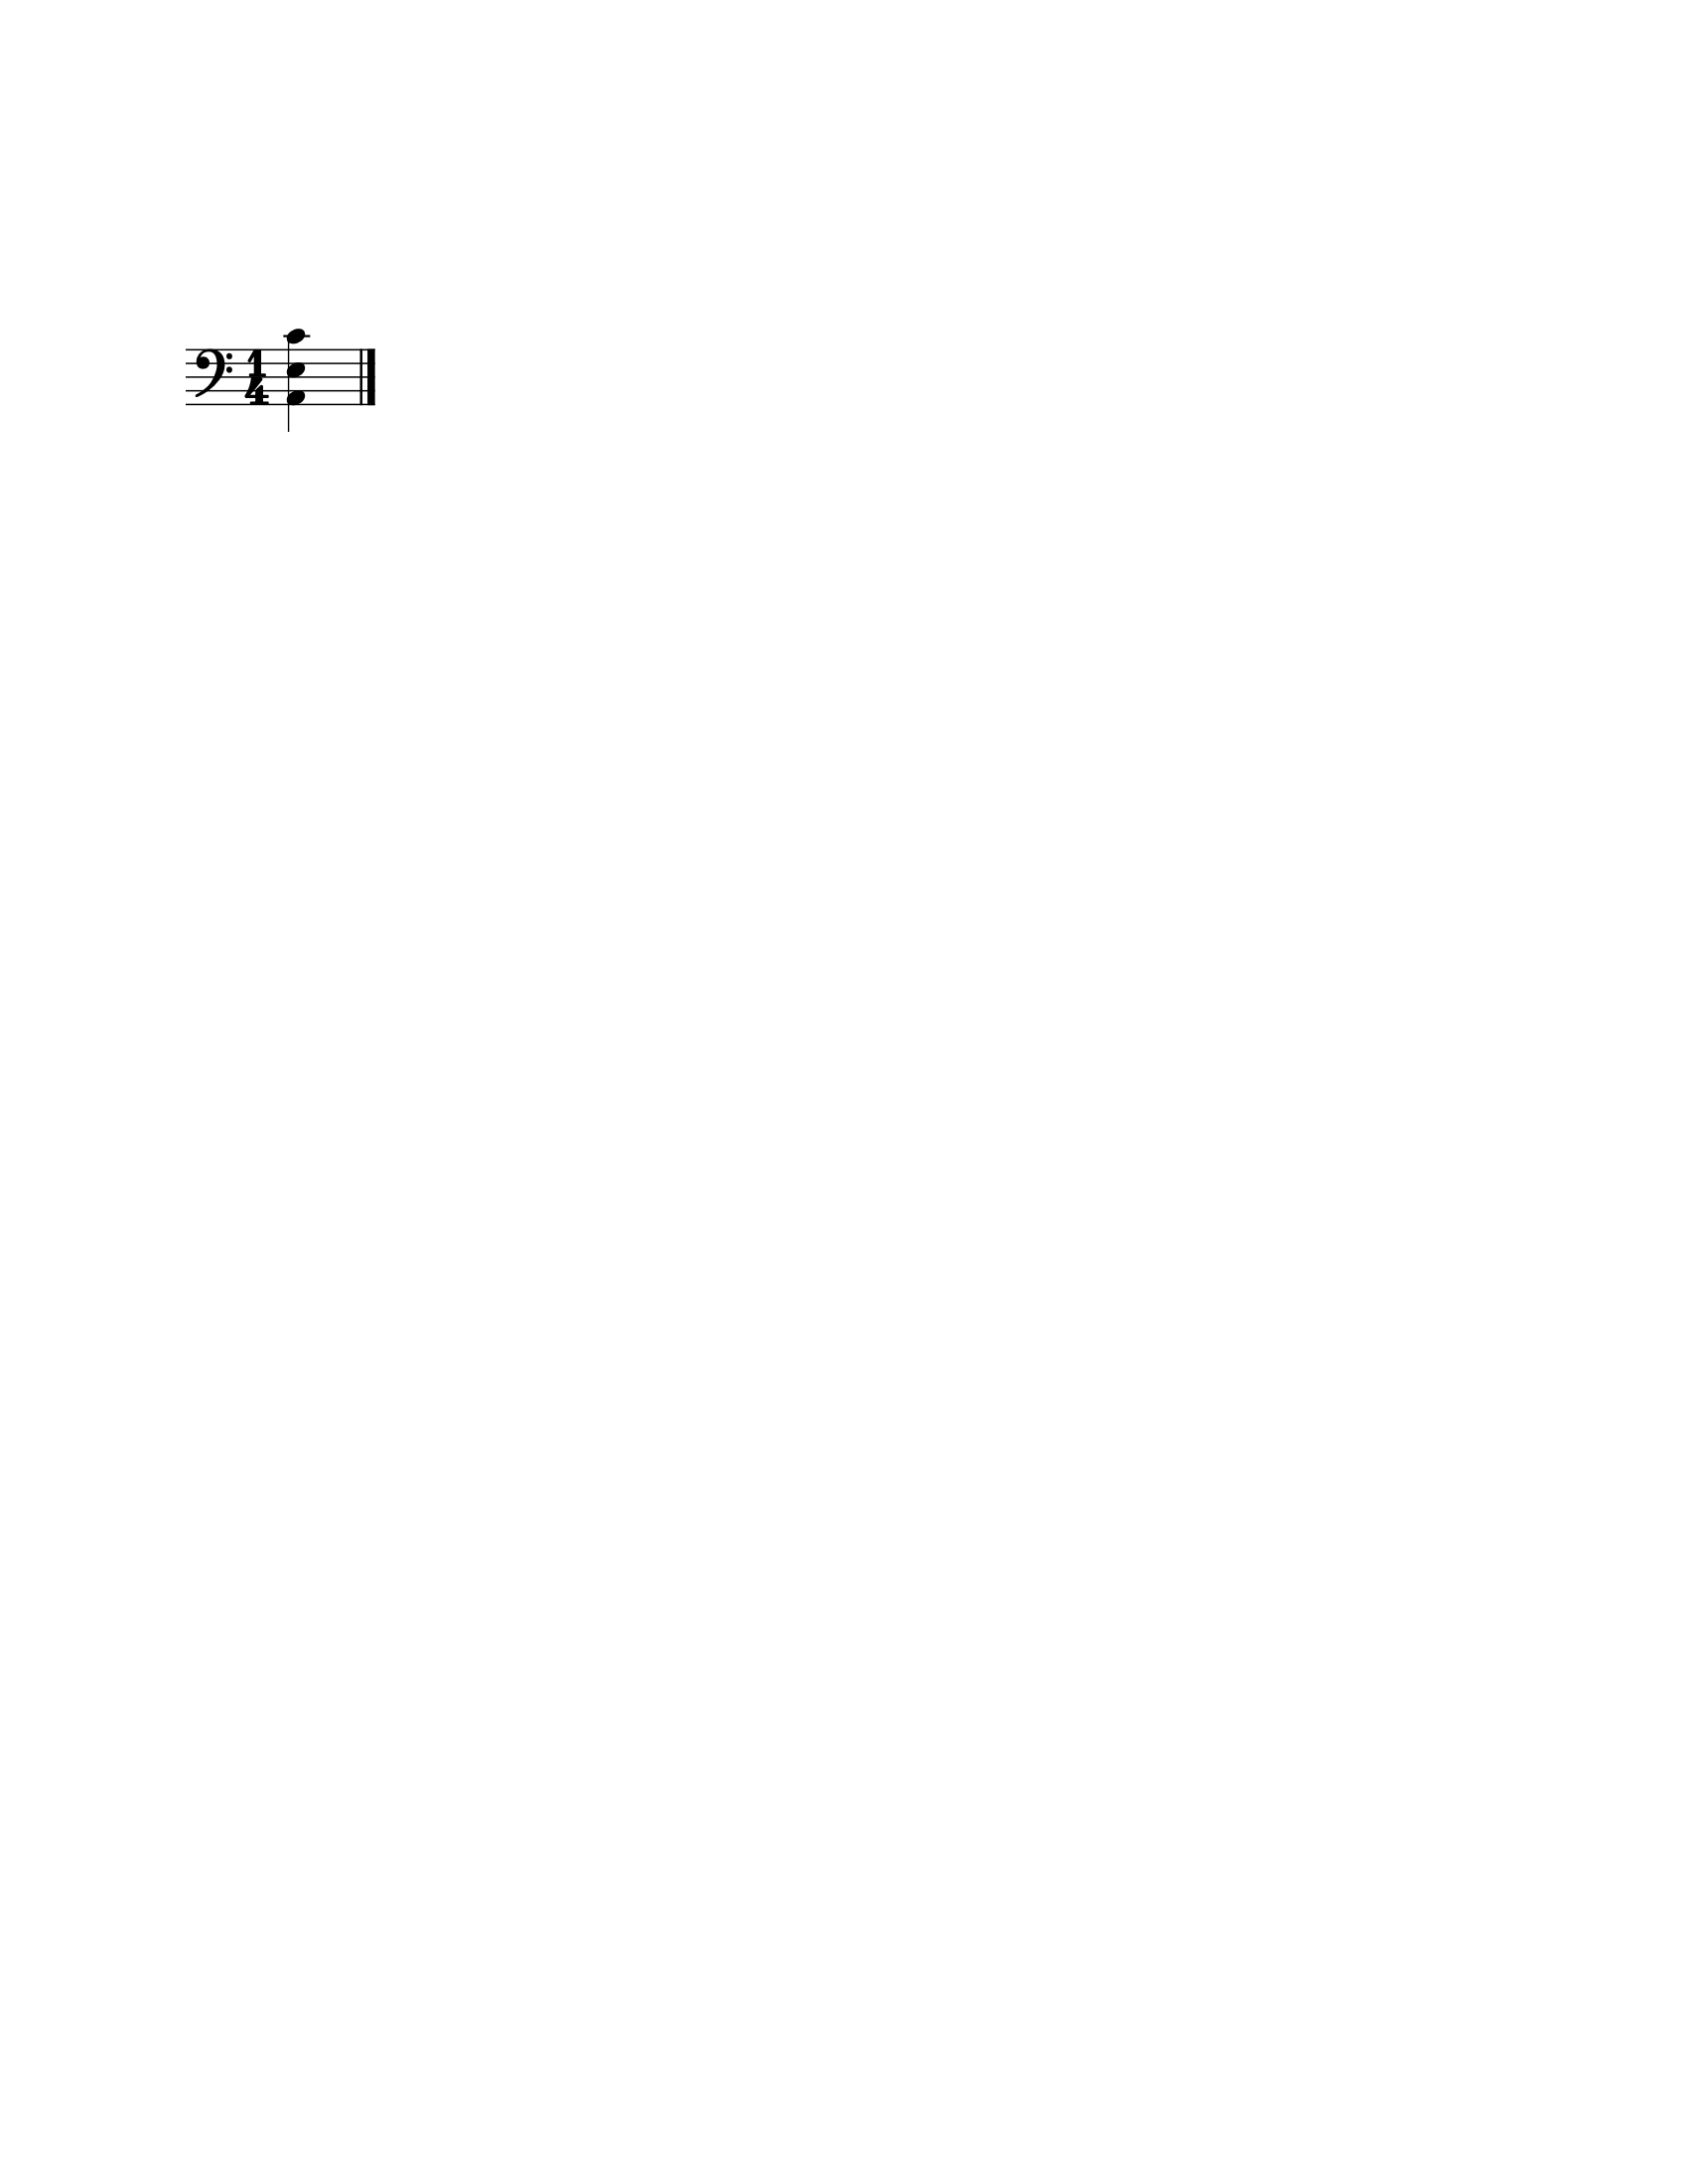

In [ ]:
c.show()

## 4. Note Encoding

Convert chord encoding to a dense matrix representation.  

Sparse Matrix (177 x 2 x 128) takes up too much space.  
Instead of 0's and 1's. Let's only keep track of when and how long a note is played.

In [ ]:
npenc = chordarr2npenc(chordarr); npenc.shape

(9, 2)

##### Encoding Dimensions: (timesteps, (pitch x duration))

18 = timesteps  
2 = note representation (pitch x duration)
* note pitch range (1-128)
  * Separator Index = -1
* note duration range (1 - 256)
  * Quarter Note = 4

#### Comparing matrix sizes:

In [ ]:
f'Chord encoding size: {np.prod(chordarr.shape)}', f'Note encoding size: {np.prod(npenc.shape)}'

('Chord encoding size: 4352', 'Note encoding size: 18')

Much smaller

#### Representation

Single note:

In [ ]:
n = npenc[0:1]; n

array([[60,  4]])

72 = C4 (note pitch)  
2 = Eighth Note (2 1/16th notes)

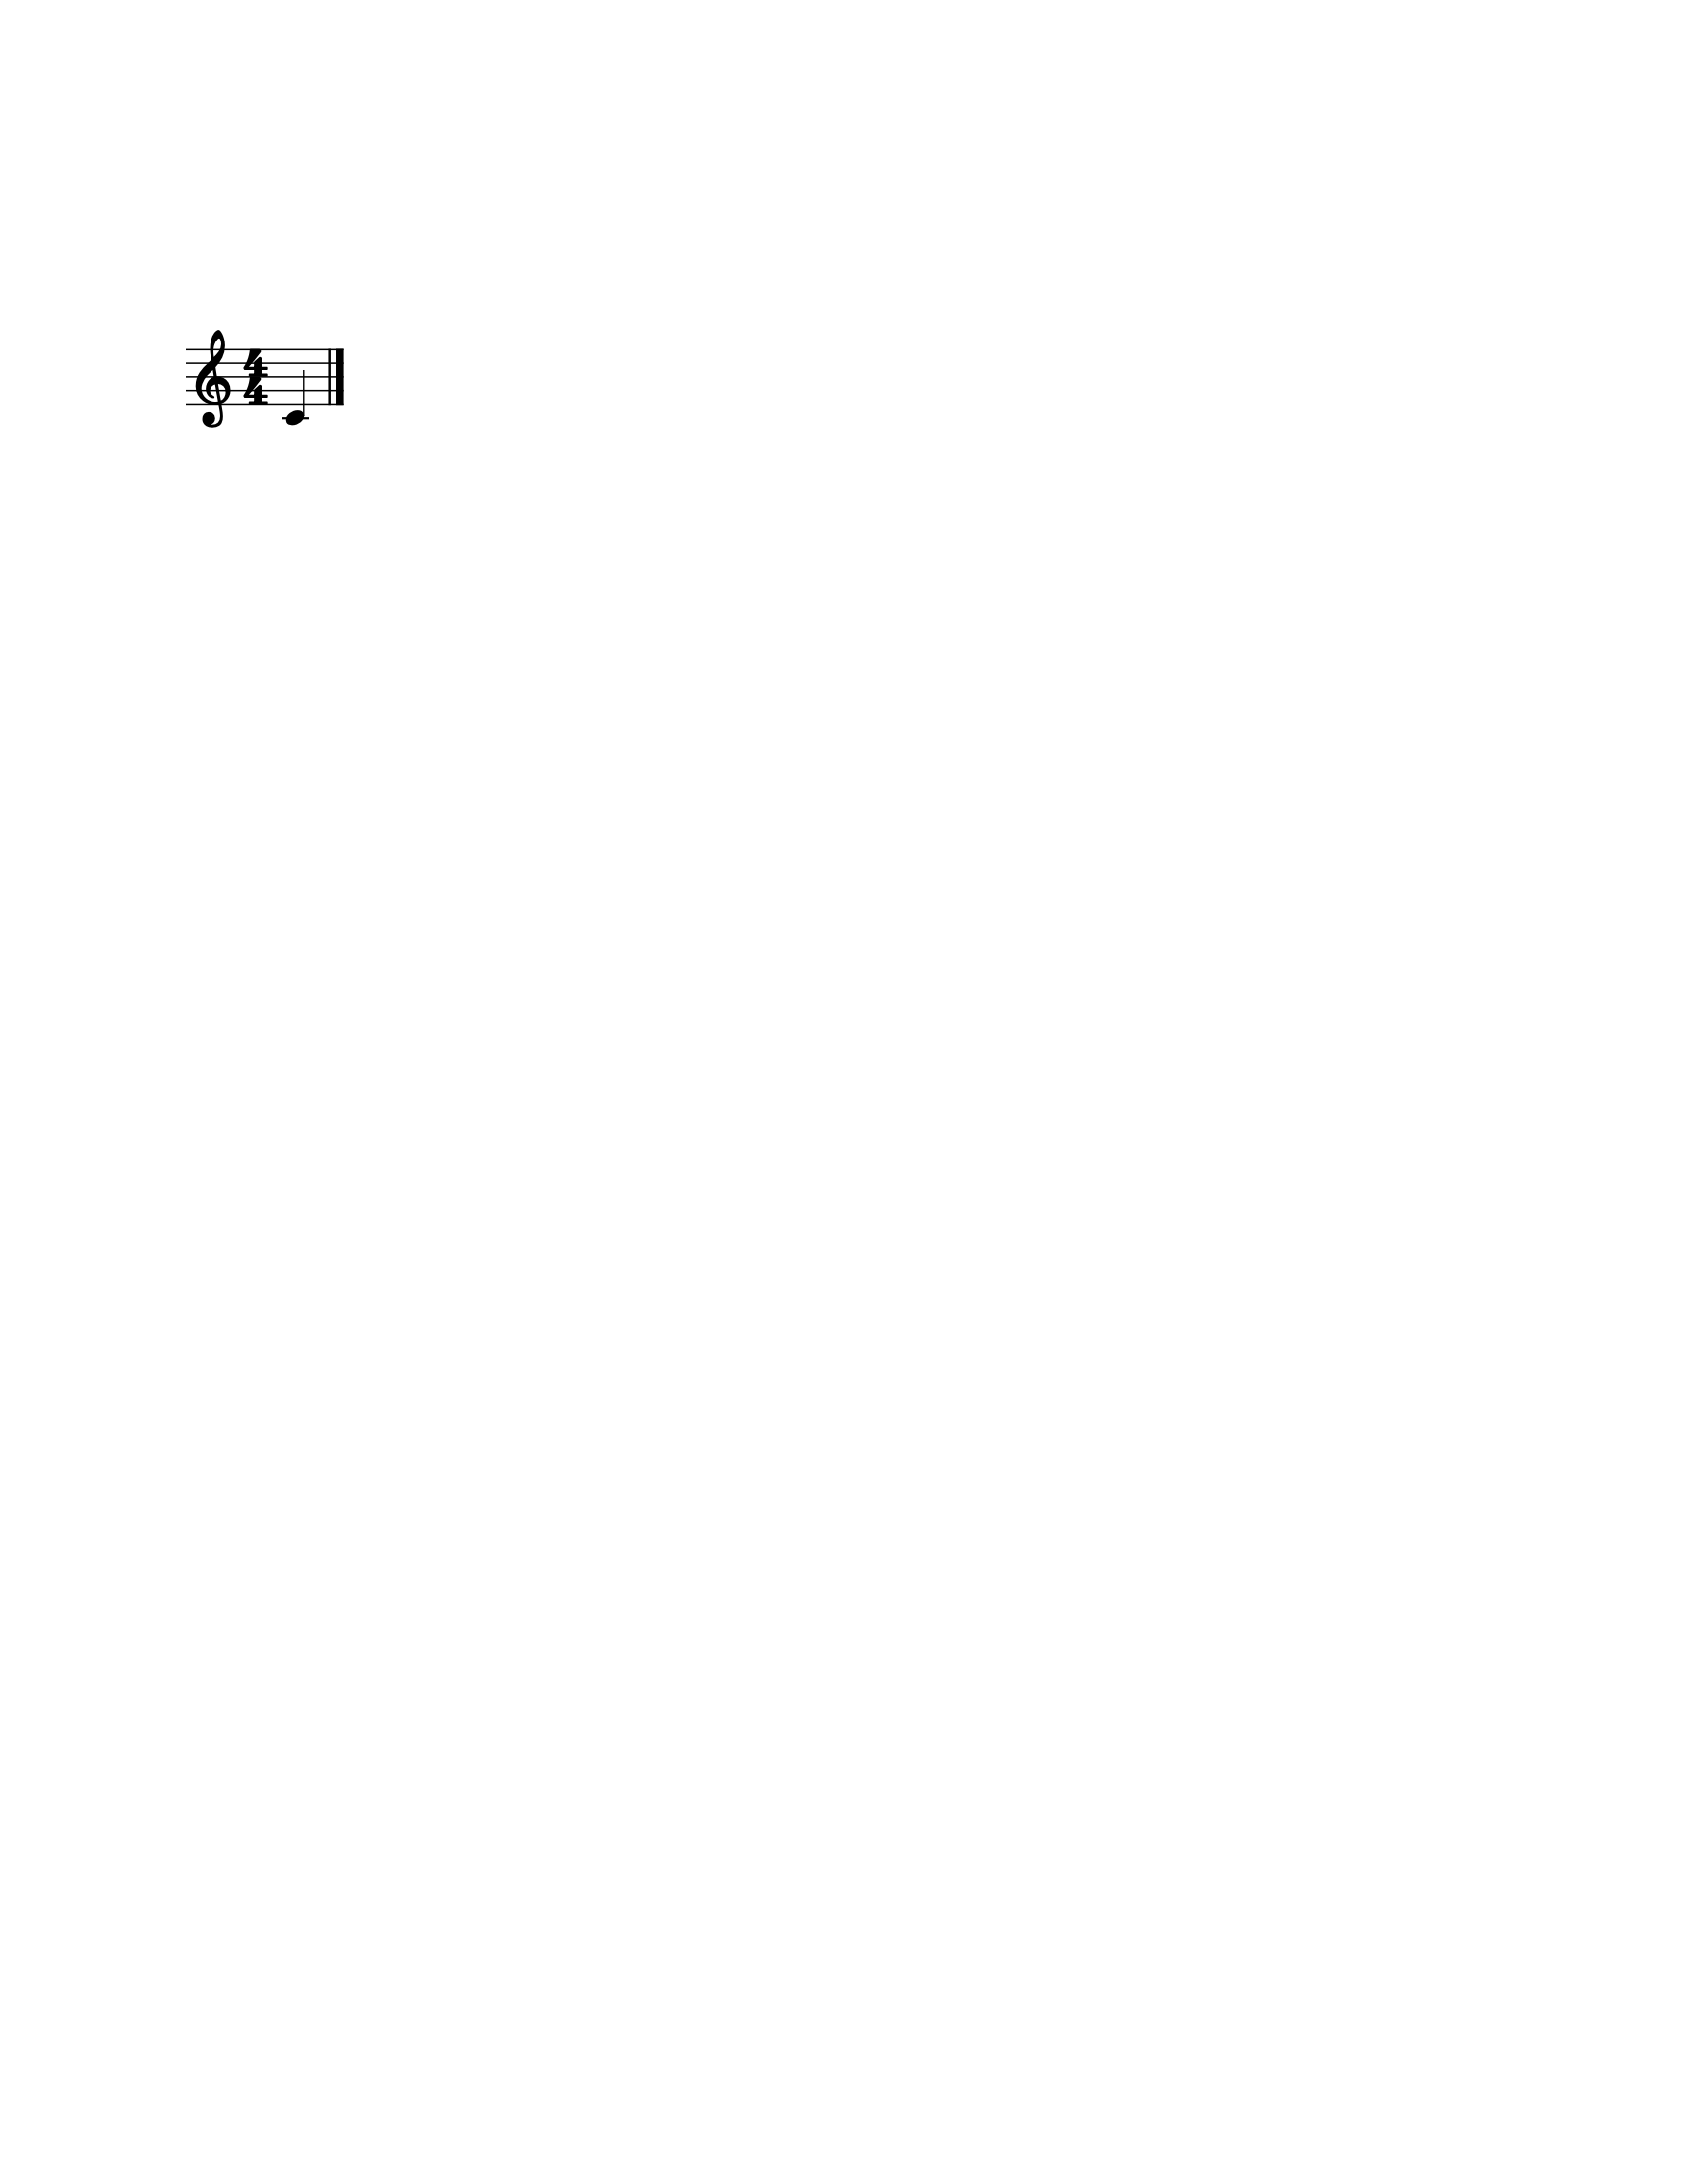

In [ ]:
npenc2stream(n).show()

Chord:

In [ ]:
c = npenc[1:4]; c

array([[52, 16],
       [48, 16],
       [45, 16]])

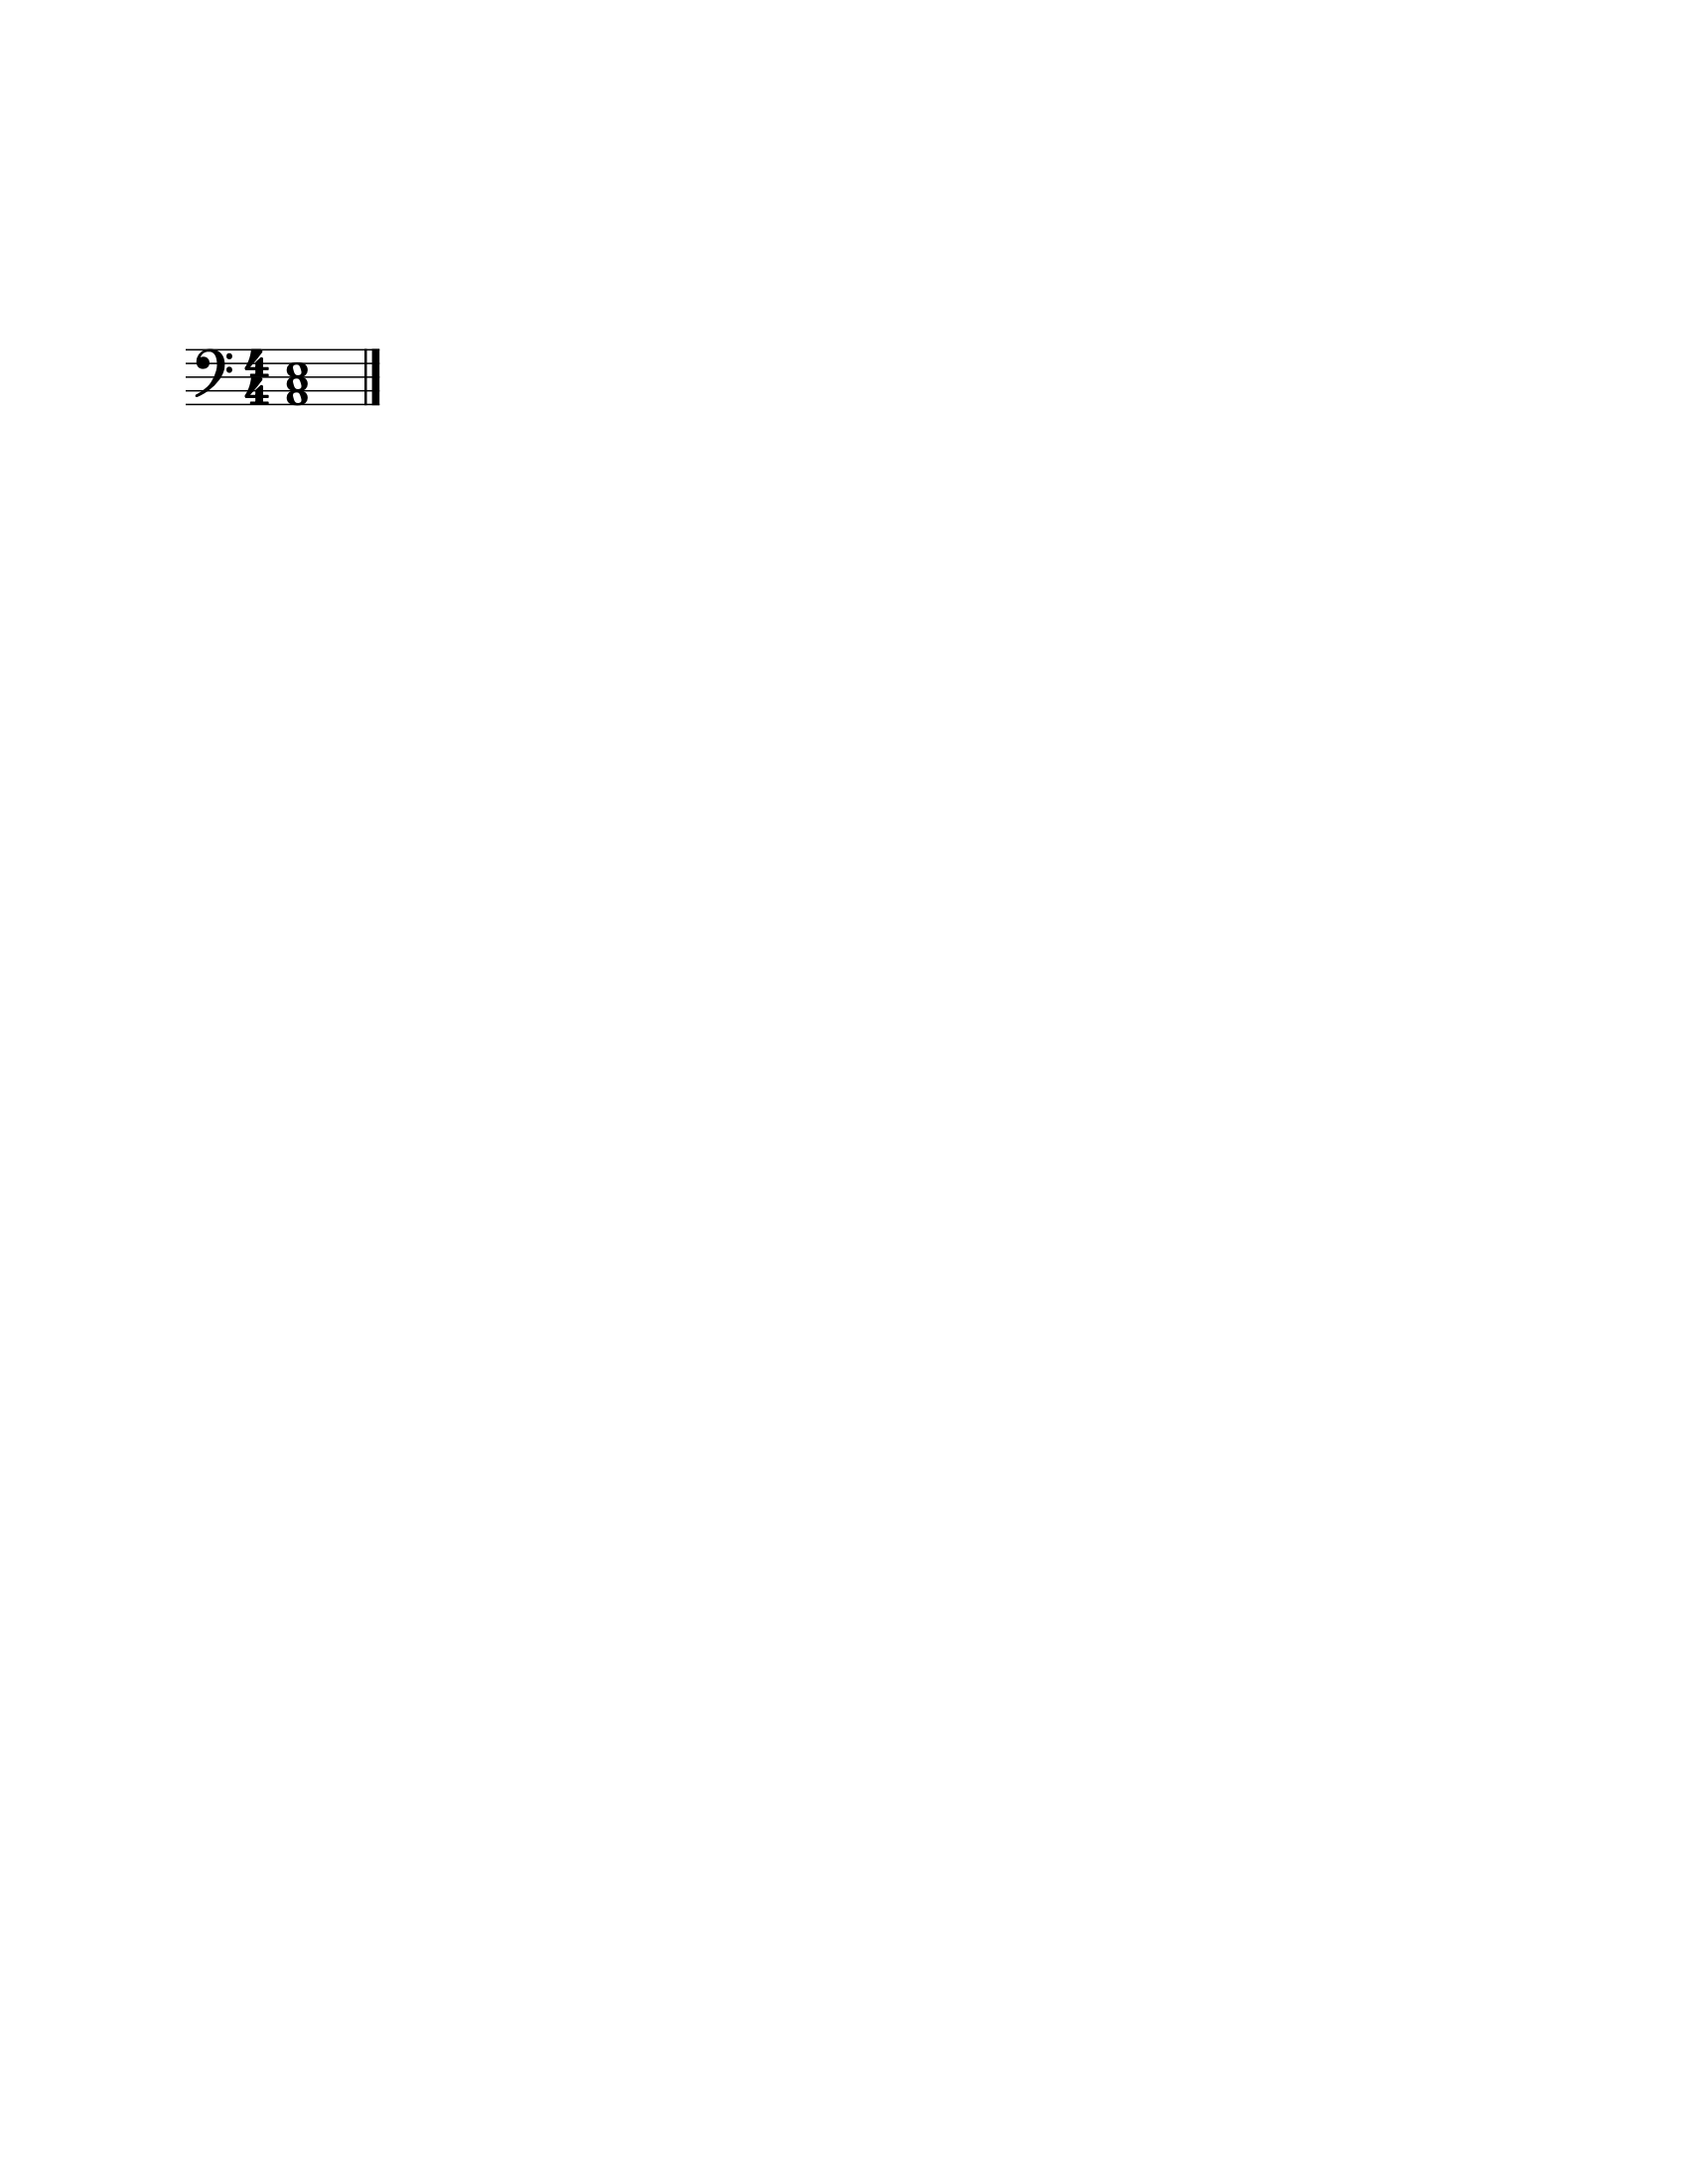

In [ ]:
npenc2stream(c).show()

#### Full Representation

In [ ]:
npenc[:8]

array([[72,  2],
       [52, 16],
       [48, 16],
       [45, 16],
       [-1,  2],
       [71,  2],
       [-1,  2],
       [71,  2]])

Note encoding represents a stream of notes followed by a `-1` index. 

`-1` is a special encoding that separates each group of notes to a different timestep.

The above basically says -
1. Play notes (72, 52, 48, 45) all at once
2. Wait (-1, 2) for 1/8th beat
3. Play (71, 2) - B4 Eighth Note
4. Wait (-1, 2) for 1/8th beat
5. Play (71, 2) - B4 Eighth Note

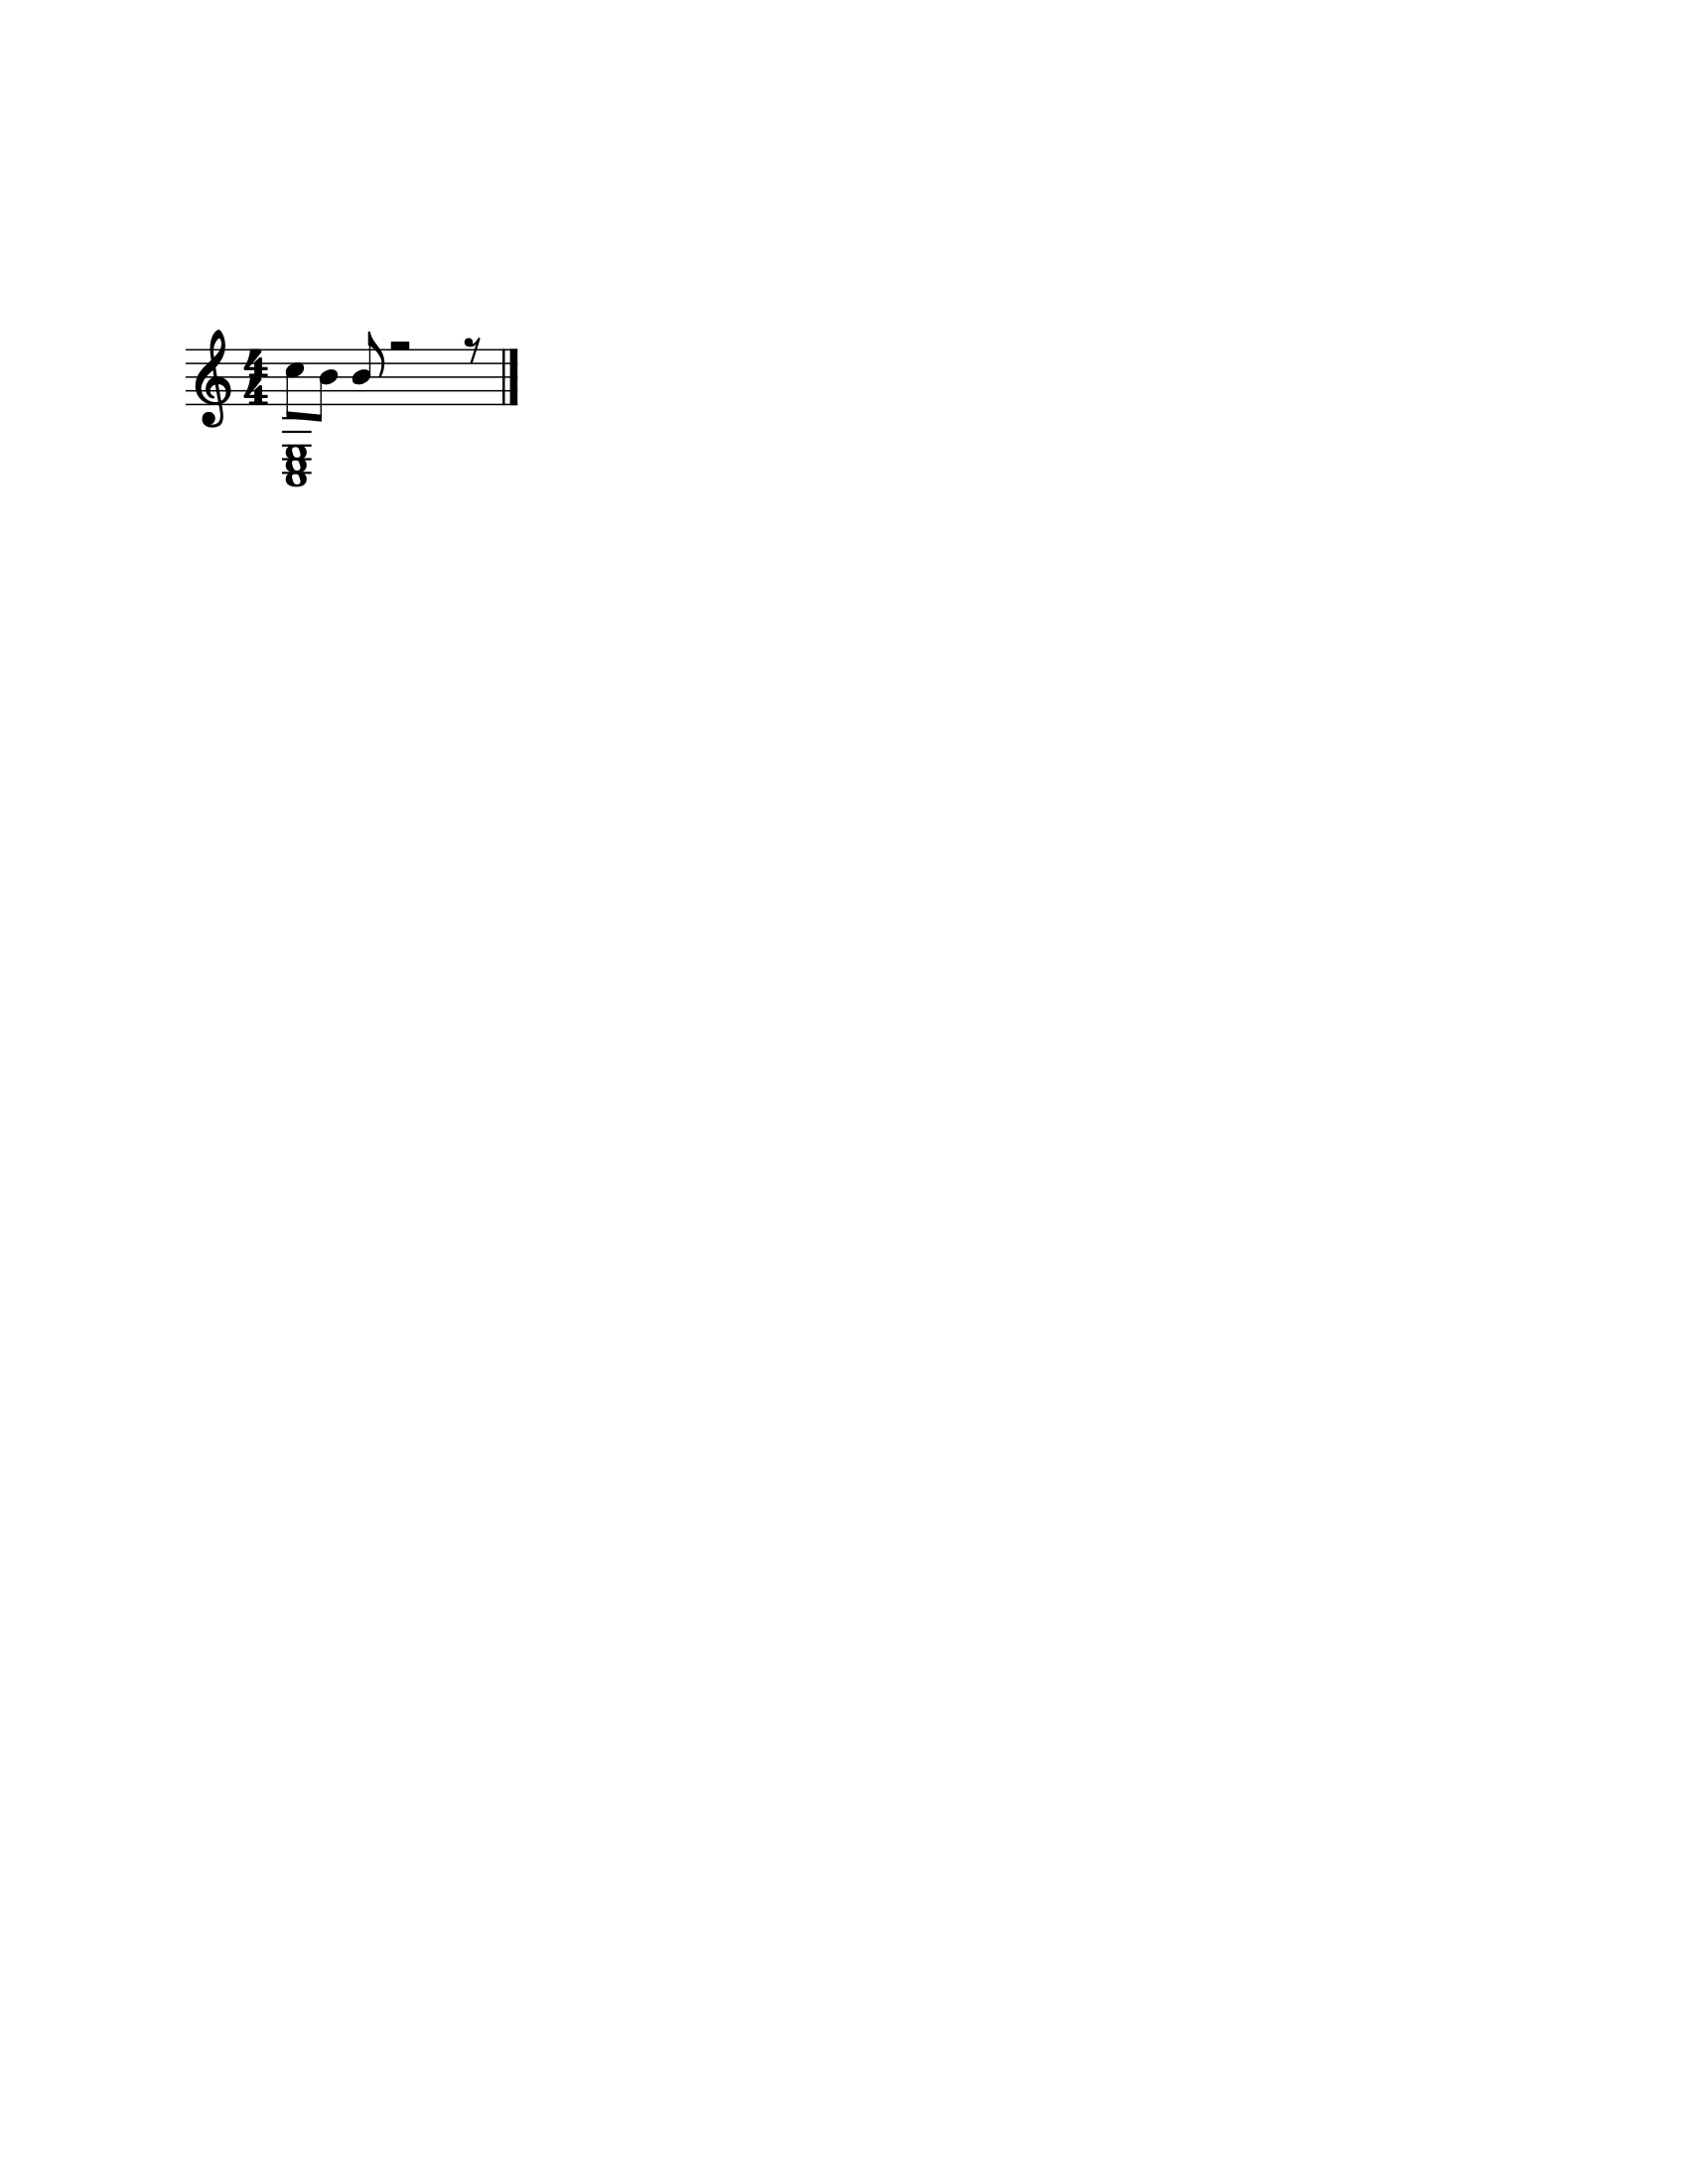

In [ ]:
npenc2stream(npenc[:8]).show()

## Tensor Encoding

Vocab indexed tensor encoding for training

In [ ]:
idxenc = npenc2idxenc(npenc, vocab); idxenc.shape

(20,)

Tensor encoding converts note encoding to a single dimensional array, required for training. 

Indexes are encoded according to the vocab dictionary -

In [ ]:
list(vocab.stoi.items())[:15]

[('xxbos', 0),
 ('xxpad', 1),
 ('xxeos', 2),
 ('xxs2scls', 3),
 ('xxmask', 4),
 ('xxcseq', 5),
 ('xxmseq', 6),
 ('xxnscls', 7),
 ('xxsep', 8),
 ('n0', 9),
 ('n1', 10),
 ('n2', 11),
 ('n3', 12),
 ('n4', 13),
 ('n5', 14)]

#### Representation

In [ ]:
idxenc

array([  0,   1,  69, 141,  61, 145,  54, 145,   8, 141,  71, 141,   8, 141,  73, 145,  64, 145,  57, 145])

More human readable:

In [ ]:
vocab.textify(idxenc)

'xxbos xxpad n60 d4 n52 d8 n45 d8 xxsep d4 n62 d4 xxsep d4 n64 d8 n55 d8 n48 d8'

'xxbos xxpad' is inserted at the beginning of each sequence so the model can distinguish when multiple music files are combined